# **Import Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
import keras
from tensorflow.keras.utils import to_categorical
import os
import matplotlib.pyplot as plt
from glob import glob
from zipfile import ZipFile
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier  
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.model_selection import StratifiedKFold
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Loading ResNet50 Features**

In [ ]:
train_features = np.load("/content/drive/MyDrive/glaucoma_project/glaucoma_resnet50_features/train_features.npy")
train_labels = np.load("/content/drive/MyDrive/glaucoma_project/glaucoma_resnet50_features/train_labels.npy")
test_labels = np.load("/content/drive/MyDrive/glaucoma_project/glaucoma_resnet50_features/test_labels.npy")
test_features = np.load("/content/drive/MyDrive/glaucoma_project/glaucoma_resnet50_features/test_features.npy")
print(train_features.shape)
print(train_labels.shape)
print(test_features.shape)
print(test_labels.shape)

(2926, 100352)
(2926, 2)
(1254, 100352)
(1254, 2)


In [ ]:
total_feat=np.concatenate((train_features,test_features))
total_label=np.concatenate((train_labels,test_labels))
print(total_feat.shape)
print(total_label.shape)

(4180, 100352)
(4180, 2)


In [ ]:
y=total_label
print(y.shape)
y1=y[:,1]
y=y1
y.shape

(4180, 2)


(4180,)

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
test = SelectKBest(score_func=chi2, k=1000)
fit = test.fit(total_feat, total_label)
np.set_printoptions(precision=3)
features = fit.transform(total_feat)
x_chai=features
x_chai.shape

(4180, 1000)

## **Grey Wolf Optimizer**

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier as KNN
import matplotlib.pyplot as plt

class Solution():    
    #structure of the solution 
    def __init__(self):
        self.num_features = None
        self.num_agents = None
        self.max_iter = None
        self.obj_function = None
        self.execution_time = None
        self.convergence_curve = {}
        self.best_agent = None
        self.best_fitness = None
        self.best_accuracy = None
        self.final_population = None
        self.final_fitness = None
        self.final_accuracy = None


class Data():
    # structure of the training data
    def __init__(self):
        self.train_X = None
        self.train_Y = None
        self.val_X = None
        self.val_Y = None



def initialize(num_agents, num_features):
    # define min and max number of features
    min_features = int(0.3 * num_features)
    max_features = int(0.6 * num_features)

    # initialize the agents with zeros
    agents = np.zeros((num_agents, num_features))

    # select random features for each agent
    for agent_no in range(num_agents):

        # find random indices
        cur_count = np.random.randint(min_features, max_features)
        temp_vec = np.random.rand(1, num_features)
        temp_idx = np.argsort(temp_vec)[0][0:cur_count]

        # select the features with the ranom indices
        agents[agent_no][temp_idx] = 1   

    return agents



def sort_agents(agents, obj, data, fitness=None):
    # sort the agents according to fitness
    train_X, val_X, train_Y, val_Y = data.train_X, data.val_X, data.train_Y, data.val_Y
    (obj_function, weight_acc) = obj
   
    if fitness is None:
        # if there is only one agent
        if len(agents.shape) == 1:
            num_agents = 1
            fitness = obj_function(agents, train_X, val_X, train_Y, val_Y, weight_acc)
            return agents, fitness

        # for multiple agents
        else:
            num_agents = agents.shape[0]
            fitness = np.zeros(num_agents)
            for id, agent in enumerate(agents):
                fitness[id] = obj_function(agent, train_X, val_X, train_Y, val_Y, weight_acc)

    idx = np.argsort(-fitness)
    sorted_agents = agents[idx].copy()
    sorted_fitness = fitness[idx].copy()

    return sorted_agents, sorted_fitness



def display(agents, fitness, agent_name='Agent'):
    # display the population
    print('\nNumber of agents: {}'.format(agents.shape[0]))
    print('\n------------- Best Agent ---------------')
    print('Fitness: {}'.format(fitness[0]))
    print('Number of Features: {}'.format(int(np.sum(agents[0]))))
    print('----------------------------------------\n')

    for id, agent in enumerate(agents):
        print('{} {} - Fitness: {}, Number of Features: {}'.format(agent_name, id+1, fitness[id], int(np.sum(agent))))

    print('================================================================================\n')



def compute_accuracy(agent, train_X, test_X, train_Y, test_Y): 
    # compute classification accuracy of the given agents
    cols = np.flatnonzero(agent)     
    if(cols.shape[0] == 0):
        return 0    
    clf = KNN()

    train_data = train_X[:,cols]
    train_label = train_Y
    test_data = test_X[:,cols]
    test_label = test_Y

    clf.fit(train_data,train_label)
    acc = clf.score(test_data,test_label)

    return acc
        

def compute_fitness(agent, train_X, test_X, train_Y, test_Y, weight_acc=0.9):
    # compute a basic fitness measure
    if(weight_acc == None):
        weight_acc = 0.9

    weight_feat = 1 - weight_acc
    num_features = agent.shape[0]
    
    acc = compute_accuracy(agent, train_X, test_X, train_Y, test_Y)
    feat = (num_features - np.sum(agent))/num_features

    fitness = weight_acc * acc + weight_feat * feat
    return fitness


def Conv_plot(convergence_curve):
    # plot convergence curves
    num_iter = len(convergence_curve['fitness'])
    iters = np.arange(num_iter) + 1
    fig, axes = plt.subplots(1)
    fig.tight_layout(pad = 5) 
    fig.suptitle('Convergence Curves')
    
    axes.set_title('Convergence of Fitness over Iterations')
    axes.set_xlabel('Iteration')
    axes.set_ylabel('Avg. Fitness')
    axes.plot(iters, convergence_curve['fitness'])

    return fig, axes

In [ ]:
import numpy as np

def sigmoid(val):
    if val < 0:
        return 1 - 1/(1 + np.exp(val))
    else:
        return 1/(1 + np.exp(-val))


def v_func(val):
    return abs(val/(np.sqrt(1 + val*val)))


def u_func(val):
    alpha, beta = 2, 1.5
    return abs(alpha * np.power(abs(val), beta))


def get_trans_function(shape):
    if (shape.lower() == 's'):
        return sigmoid

    elif (shape.lower() == 'v'):
        return v_func

    elif(shape.lower() == 'u'):
        return u_func

    else:
        print('\n[Error!] We don\'t currently support {}-shaped transfer functions...\n'.format(shape))
        exit(1)


Weight for the classification accuracy [0-1]: 1
Enter the percentage of data wanted for valdiation [0, 100]: 30

                          Iteration - 1


Number of agents: 5

------------- Best Agent ---------------
Fitness: 0.8708133971291866
Number of Features: 615
----------------------------------------

Greywolf 1 - Fitness: 0.8708133971291866, Number of Features: 615
Greywolf 2 - Fitness: 0.8692185007974481, Number of Features: 600
Greywolf 3 - Fitness: 0.8692185007974481, Number of Features: 584
Greywolf 4 - Fitness: 0.868421052631579, Number of Features: 607
Greywolf 5 - Fitness: 0.8660287081339713, Number of Features: 604


                          Iteration - 2


Number of agents: 5

------------- Best Agent ---------------
Fitness: 0.8700159489633174
Number of Features: 649
----------------------------------------

Greywolf 1 - Fitness: 0.8700159489633174, Number of Features: 649
Greywolf 2 - Fitness: 0.868421052631579, Number of Features: 624
Greywolf 3 - Fitness: 0.86762

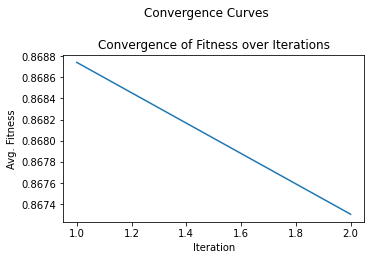

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import datasets

#from Py_FS.wrapper.nature_inspired._utilities import Solution, Data, initialize, sort_agents, display, compute_fitness, Conv_plot
#from Py_FS.wrapper.nature_inspired._transfer_functions import get_trans_function


def GWO(num_agents, max_iter, train_data, train_label, obj_function=compute_fitness, trans_func_shape='s', save_conv_graph=False):
    
    # Grey Wolf Optimizer
    ############################### Parameters ####################################
    #                                                                             #
    #   num_agents: number of greywolves                                          #
    #   max_iter: maximum number of generations                                   #
    #   train_data: training samples of data                                      #
    #   train_label: class labels for the training samples                        #                
    #   obj_function: the function to maximize while doing feature selection      #
    #   trans_function_shape: shape of the transfer function used                 #
    #   save_conv_graph: boolean value for saving convergence graph               #
    #                                                                             #
    ###############################################################################
    
    short_name = 'GWO'
    agent_name = 'Greywolf'
    train_data, train_label = np.array(train_data), np.array(train_label)
    num_features = train_data.shape[1]
    trans_function = get_trans_function(trans_func_shape)

    # setting up the objectives
    weight_acc = None
    if(obj_function==compute_fitness):
        weight_acc = float(input('Weight for the classification accuracy [0-1]: '))
    obj = (obj_function, weight_acc)
    compute_accuracy = (compute_fitness, 1) # compute_accuracy is just compute_fitness with accuracy weight as 1

    # initialize greywolves and Leader (the agent with the max fitness)
    greywolves = initialize(num_agents, num_features)
    fitness = np.zeros(num_agents)
    accuracy = np.zeros(num_agents)
    Leader_agent = np.zeros((1, num_features))
    Leader_fitness = float("-inf")
    Leader_accuracy = float("-inf")

    # initialize convergence curves
    convergence_curve = {}
    convergence_curve['fitness'] = np.zeros(max_iter)

    # initialize data class
    data = Data()
    val_size = float(input('Enter the percentage of data wanted for valdiation [0, 100]: '))/100
    data.train_X, data.val_X, data.train_Y, data.val_Y = train_test_split(train_data, train_label, stratify=train_label, test_size=val_size)
    
    # create a solution object
    solution = Solution()
    solution.num_agents = num_agents
    solution.max_iter = max_iter
    solution.num_features = num_features
    solution.obj_function = obj_function

    # rank initial greywolves
    greywolves, fitness = sort_agents(greywolves, obj, data)

    # start timer
    start_time = time.time()

    # initialize the alpha, beta and delta grey wolves and their fitness
    alpha, beta, delta = np.zeros((1, num_features)), np.zeros((1, num_features)), np.zeros((1, num_features))
    alpha_fit, beta_fit, delta_fit = float("-inf"), float("-inf"), float("-inf")

    for iter_no in range(max_iter):
        print('\n================================================================================')
        print('                          Iteration - {}'.format(iter_no+1))
        print('================================================================================\n')

        # update the alpha, beta and delta grey wolves
        for i in range(num_agents):

            # update alpha, beta, delta
            if fitness[i] > alpha_fit:
                delta_fit = beta_fit
                delta = beta.copy()
                beta_fit = alpha_fit
                beta = alpha.copy()
                alpha_fit = fitness[i]
                alpha = greywolves[i, :].copy()

            # update beta, delta
            elif fitness[i] > beta_fit:
                delta_fit = beta_fit
                delta = beta.copy()
                beta_fit = fitness[i]
                beta = greywolves[i, :].copy()

            # update delta
            elif fitness[i] > delta_fit:
                delta_fit = fitness[i]
                delta = greywolves[i, :].copy()

        # a decreases linearly fron 2 to 0
        a = 2-iter_no*((2)/max_iter)

        for i in range(num_agents):
            for j in range(num_features):  

                # calculate distance between alpha and current agent
                r1 = np.random.random() # r1 is a random number in [0,1]
                r2 = np.random.random() # r2 is a random number in [0,1]
                A1 = (2 * a * r1) - a # calculate A1 
                C1 = 2 * r2 # calculate C1
                D_alpha = abs(C1 * alpha[j] - greywolves[i, j]) # find distance from alpha
                X1 = alpha[j] - (A1 * D_alpha) # Eq. (3.6)

                # calculate distance between beta and current agent
                r1 = np.random.random() # r1 is a random number in [0,1]
                r2 = np.random.random() # r2 is a random number in [0,1]
                A2 = (2 * a * r1) - a # calculate A2
                C2 = 2 * r2 # calculate C2
                D_beta = abs(C2 * beta[j] - greywolves[i, j]) # find distance from beta
                X2 = beta[j] - (A2 * D_beta) # Eq. (3.6)

                # calculate distance between delta and current agent
                r1 = np.random.random() # r1 is a random number in [0,1]
                r2 = np.random.random() # r2 is a random number in [0,1]
                A3 = (2* a * r1) - a # calculate A3
                C3 = 2 * r2 # calculate C3
                D_delta = abs(C3 * delta[j] - greywolves[i, j]) # find distance from delta
                X3 = delta[j]-A3*D_delta # Eq. (3.6)

                # update the position of current agent
                greywolves[i, j] = (X1 + X2 + X3) / 3 # Eq. (3.7)

            # Apply transformation function on the updated greywolf
            for j in range(num_features):
                trans_value = trans_function(greywolves[i,j])
                if (np.random.random() < trans_value): 
                    greywolves[i,j] = 1
                else:
                    greywolves[i,j] = 0

        # update final information
        greywolves, fitness = sort_agents(greywolves, obj, data)
        display(greywolves, fitness, agent_name)
        
        # update Leader (best agent)
        if fitness[0] > Leader_fitness:
            Leader_agent = greywolves[0].copy()
            Leader_fitness = fitness[0].copy()

        if alpha_fit > Leader_fitness:
            Leader_fitness = alpha_fit
            Leader_agent = alpha.copy()


        convergence_curve['fitness'][iter_no] = np.mean(fitness)


    # compute final accuracy
    Leader_agent, Leader_accuracy = sort_agents(Leader_agent, compute_accuracy, data)
    greywolves, accuracy = sort_agents(greywolves, compute_accuracy, data)

    print('\n================================================================================')
    print('                                    Final Result                                  ')
    print('================================================================================\n')
    print('Leader ' + agent_name + ' Dimension : {}'.format(int(np.sum(Leader_agent))))
    print('Leader ' + agent_name + ' Fitness : {}'.format(Leader_fitness))
    print('Leader ' + agent_name + ' Classification Accuracy : {}'.format(Leader_accuracy))
    print('\n================================================================================\n')

    # stop timer
    end_time = time.time()
    exec_time = end_time - start_time

    # plot convergence graph
    fig, axes = Conv_plot(convergence_curve)
    if(save_conv_graph):
        plt.savefig('convergence_graph_'+ short_name + '.jpg')
    plt.show()

    # update attributes of solution
    solution.best_agent = Leader_agent
    solution.best_fitness = Leader_fitness
    solution.best_accuracy = Leader_accuracy
    solution.convergence_curve = convergence_curve
    solution.final_greywolves = greywolves
    solution.final_fitness = fitness
    solution.final_accuracy = accuracy
    solution.execution_time = exec_time

    return solution


if __name__ == '__main__':

    #data = datasets.load_digits()
    solution=GWO(5, 2, x_chai, y, save_conv_graph=True)

In [ ]:
cols=np.flatnonzero(solution.best_agent)

In [ ]:
final_x=x_chai[:,cols]
final_y=y


In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(final_x,final_y,test_size=0.3, random_state=2)

In [ ]:
print(train_features.shape)
print(train_labels.shape)
print(test_features.shape)
print(test_labels.shape)

(2926, 615)
(2926,)
(1254, 615)
(1254,)


In [ ]:
ytrain = train_labels
ytrain.shape

(2926,)

In [ ]:
ytest = test_labels
ytest.shape

(1254,)

## **Classification(ML Classifiers)**

### **(i).KNeighbors Classifier**

In [ ]:
start = time.time()
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
classifier = knn.fit(train_features,ytrain)
end = time.time()
print('Time_Consumed',end-start)

Time_Consumed 0.0032570362091064453


In [ ]:
ytrainpred = classifier.predict(train_features)
ytestpred = classifier.predict(test_features)

In [ ]:
from sklearn.metrics import classification_report
print('Train_Classification_Report')
print('---------------------------')
print(classification_report(ytrain,ytrainpred))

Train_Classification_Report
---------------------------
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91      1458
         1.0       0.93      0.88      0.91      1468

    accuracy                           0.91      2926
   macro avg       0.91      0.91      0.91      2926
weighted avg       0.91      0.91      0.91      2926



In [ ]:
print('Test_Classification_Report')
print('---------------------------')
print(classification_report(ytest,ytestpred))

Test_Classification_Report
---------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88       632
         1.0       0.90      0.85      0.87       622

    accuracy                           0.88      1254
   macro avg       0.88      0.88      0.88      1254
weighted avg       0.88      0.88      0.88      1254



### **(ii).Naive Bayes**

In [ ]:
start = time.time()
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
classifier = gnb.fit(train_features,ytrain)
end = time.time()
print('Time_Consumed',end-start)

Time_Consumed 0.0786900520324707


In [ ]:
ytrainpred = classifier.predict(train_features)
ytestpred = classifier.predict(test_features)

In [ ]:
from sklearn.metrics import classification_report
print('Train_Classification_Report')
print('---------------------------')
print(classification_report(ytrain,ytrainpred))

Train_Classification_Report
---------------------------
              precision    recall  f1-score   support

         0.0       0.71      0.74      0.73      1458
         1.0       0.73      0.70      0.72      1468

    accuracy                           0.72      2926
   macro avg       0.72      0.72      0.72      2926
weighted avg       0.72      0.72      0.72      2926



In [ ]:
print('Test_Classification_Report')
print('---------------------------')
print(classification_report(ytest,ytestpred))

Test_Classification_Report
---------------------------
              precision    recall  f1-score   support

         0.0       0.70      0.77      0.73       632
         1.0       0.74      0.67      0.70       622

    accuracy                           0.72      1254
   macro avg       0.72      0.72      0.72      1254
weighted avg       0.72      0.72      0.72      1254



### **(iii).SVM**

In [ ]:
start = time.time()
svc = SVC(kernel ='poly', C = 1)
classifier = svc.fit(train_features,ytrain)
end = time.time()
print('Time_Consumed',end-start)

Time_Consumed 1.0750439167022705


In [ ]:
ytrainpred = classifier.predict(train_features)
ytestpred = classifier.predict(test_features)

In [ ]:
from sklearn.metrics import classification_report
print('Train_Classification_Report')
print('---------------------------')
print(classification_report(ytrain,ytrainpred))

Train_Classification_Report
---------------------------
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      1458
         1.0       0.98      0.94      0.96      1468

    accuracy                           0.96      2926
   macro avg       0.96      0.96      0.96      2926
weighted avg       0.96      0.96      0.96      2926



In [ ]:
print('Test_Classification_Report')
print('---------------------------')
print(classification_report(ytest,ytestpred))

Test_Classification_Report
---------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88       632
         1.0       0.90      0.86      0.88       622

    accuracy                           0.88      1254
   macro avg       0.88      0.88      0.88      1254
weighted avg       0.88      0.88      0.88      1254



### **(iv).AdaBoostClassifier**

In [ ]:
start = time.time()
from sklearn.ensemble import AdaBoostClassifier
ab = AdaBoostClassifier()
classifier = ab.fit(train_features,ytrain)
end = time.time()
print('Time_Consumed',end-start)

Time_Consumed 8.190357208251953


In [ ]:
ytrainpred = classifier.predict(train_features)
ytestpred = classifier.predict(test_features)

In [ ]:
print('Train_Classification_Report')
print('---------------------------')
print(classification_report(ytrain,ytrainpred))

Train_Classification_Report
---------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88      1458
         1.0       0.88      0.88      0.88      1468

    accuracy                           0.88      2926
   macro avg       0.88      0.88      0.88      2926
weighted avg       0.88      0.88      0.88      2926



In [ ]:
print('Test_Classification_Report')
print('---------------------------')
print(classification_report(ytest,ytestpred))

Test_Classification_Report
---------------------------
              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80       632
         1.0       0.79      0.81      0.80       622

    accuracy                           0.80      1254
   macro avg       0.80      0.80      0.80      1254
weighted avg       0.80      0.80      0.80      1254



### **(v).GradientBoostingClassifier**

In [ ]:
start = time.time()
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
classifier = ab.fit(train_features,ytrain)
end = time.time()
print('Time_Consumed',end-start)

Time_Consumed 8.582406520843506


In [ ]:
ytrainpred = classifier.predict(train_features)
ytestpred = classifier.predict(test_features)

In [ ]:
print('Train_Classification_Report')
print('---------------------------')
print(classification_report(ytrain,ytrainpred))

Train_Classification_Report
---------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88      1458
         1.0       0.88      0.88      0.88      1468

    accuracy                           0.88      2926
   macro avg       0.88      0.88      0.88      2926
weighted avg       0.88      0.88      0.88      2926



In [ ]:
print('Test_Classification_Report')
print('---------------------------')
print(classification_report(ytest,ytestpred))

Test_Classification_Report
---------------------------
              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80       632
         1.0       0.79      0.81      0.80       622

    accuracy                           0.80      1254
   macro avg       0.80      0.80      0.80      1254
weighted avg       0.80      0.80      0.80      1254

